# Predict admissions from new data

Use some made up MSOA demographics.

## Code setup

In [62]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Linear regression fits to create health proportions from ages:

In [63]:
df_health_lines = pl.read_csv(os.path.join('outputs', 'line_fits_age_to_health.csv'))

df_health_lines.head()

imd_bin_min,imd_bin_max,col_age,col_health,m,c,rsquared
f64,f64,str,str,f64,f64,f64
2.2122,7.708,"""age_less65_proportion""","""prop_good_health""",0.3543778,0.5874175,0.6364851
2.2122,7.708,"""age_less65_proportion""","""prop_fair health""",-0.264882,0.3105843,0.6541842
2.2122,7.708,"""age_less65_proportion""","""prop_bad health""",-0.089496,0.1019982,0.4586286
2.2122,7.708,"""age_65_proportion""","""prop_good_health""",-1.484968,0.9440812,0.4800753
2.2122,7.708,"""age_65_proportion""","""prop_fair health""",1.1150576,0.0437121,0.497979


Linear regression fits to create admissions from health proportions:

In [64]:
df_admissions_lines = pl.read_csv(os.path.join('outputs', 'line_fits_health_to_admissions.csv'))

df_admissions_lines.head()

imd_bin_min,imd_bin_max,coeff_good_health,coeff_fair_health,coeff_bad_health,rsquared
f64,f64,f64,f64,f64,f64
2.2122,7.708,0.0,0.008549,0.017694,0.5722268
7.708,10.369,0.0,0.0101521,0.0091246,0.5156227
10.369,12.74375,0.0,0.0118571,0.0027425,0.5254204
12.74375,15.2564,0.0,0.0119053,0.0023227,0.565176
15.2564,18.32929,0.0,0.0121379,0.0,0.5270501


MSOA demographic data to base the invented data on:

In [65]:
path_to_msoa_stats = os.path.join('data', 'msoa_cleaned.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [66]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Check sum of admissions for Welsh areas:

In [67]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [68]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

Recalculate total numbers of patients:

In [69]:
df_stats = df_stats.with_columns((pl.col('good_health') + pl.col('fair health') + pl.col('bad health')).alias('total_health'))

In [70]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion,total_health
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062,8524
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692,6634
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661,7100
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638,10127
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662,8526


In [71]:
dict_quantiles = {}

for q in np.arange(0.0, 1.01, 0.1):
    v = df_stats['IMD2019Score'].quantile(q)
    dict_quantiles[round(q, 1)] = round(v, 5)

In [72]:
dict_quantiles

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996,
 1.0: 87.02675}

Pick out just the values for the left edges of the bins:

In [73]:
imd_bin_left_edges = {}
for k in list(dict_quantiles.keys())[:-1]:
    imd_bin_left_edges[k] = dict_quantiles[k]

In [74]:
imd_bin_left_edges

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996}

Place MSOA into these bins:

In [75]:
# Make columns for the results with a placeholder value:
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_min'))
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_max'))

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    # Pick out the bin edges:
    q0 = dict_quantiles[quantile]
    q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
    # Find a mask for the demographic data that contains
    # only MSOA with IMD scores in this bin.
    mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
    if q == len(dict_quantiles) - 2:
        # Also allow values at the right edge of the final bin.
        mask = mask | (df_stats['IMD2019Score'] == q1)

    # Update the bin min/max values for these rows:
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q0)         # replace with bin min
        .otherwise(pl.col('imd_bin_min'))  # otherwise keep the existing value
        .name.keep()
    )
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q1)         # replace with bin min
        .otherwise(pl.col('imd_bin_max'))  # otherwise keep the existing value
        .name.keep()
    )

Check that data was binned correctly:

In [76]:
df_stats[['IMD2019Score', 'imd_bin_min', 'imd_bin_max']]

IMD2019Score,imd_bin_min,imd_bin_max
f64,f64,f64
16.924833,15.2564,18.32929
6.4704,2.2122,7.708
13.7334,12.74375,15.2564
26.199857,21.81475,26.36117
11.7948,10.369,12.74375
…,…,…
3.25925,2.2122,7.708
7.29475,2.2122,7.708
12.117,10.369,12.74375


Remove any data that we'll be recalculating:

In [77]:
cols_to_drop = ['admissions', 'All persons', 'country', 'good_health', 'fair health', 'bad health', 'prop_good_health', 'prop_fair health', 'prop_bad health', 'MSOA11CD']

df_stats = df_stats.drop(cols_to_drop)

In [78]:
df_stats.head()

MSOA,IMD2019Score,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion,total_health,imd_bin_min,imd_bin_max
str,f64,f64,f64,f64,f64,f64,i64,f64,f64
"""Adur 001""",16.924833,0.0559,0.0528,0.0422,0.7872,0.062,8524,15.2564,18.32929
"""Adur 002""",6.4704,0.0578,0.0774,0.0492,0.7467,0.0692,6634,2.2122,7.708
"""Adur 003""",13.7334,0.0609,0.0582,0.0421,0.7729,0.0661,7100,12.74375,15.2564
"""Adur 004""",26.199857,0.0465,0.0438,0.0367,0.8091,0.0638,10127,21.81475,26.36117
"""Adur 005""",11.7948,0.0597,0.067,0.0425,0.7643,0.0662,8526,10.369,12.74375


## Invent new age proportions

In [83]:
df_stats = df_stats.with_columns(pl.Series(name='new_age_65_proportion', values=0.1 * df_stats['age_less65_proportion']))
df_stats = df_stats.with_columns(pl.Series(name='new_age_70_proportion', values=df_stats['age_65_proportion']*0.8))
df_stats = df_stats.with_columns(pl.Series(name='new_age_75_proportion', values=df_stats['age_70_proportion']*0.8))
df_stats = df_stats.with_columns(pl.Series(name='new_age_over80_proportion', values=df_stats['age_75_proportion']*0.8 + 0.3 * df_stats['age_over80_proportion']))
df_stats = df_stats.with_columns(pl.Series(name='new_age_less65_proportion', values=1.0 - df_stats[['new_age_65_proportion', 'new_age_70_proportion', 'new_age_75_proportion', 'new_age_over80_proportion']].sum_horizontal()))

Pick out column names for the health and age proportions:

In [87]:
health_numbers = ['good_health', 'fair health', 'bad health']
props_health = ['prop_good_health', 'prop_fair health', 'prop_bad health']
props_age = [
    'age_less65_proportion', 'age_65_proportion', 'age_70_proportion',
    'age_75_proportion', 'age_over80_proportion'
]

In [91]:
df_stats = df_stats.rename(dict([(c, f'old_{c}') for c in props_age]))
df_stats = df_stats.rename(dict([(f'new_{c}', c) for c in props_age]))

In [93]:
df_stats = df_stats.drop([c for c in df_stats.columns if c.startswith('old')])

In [94]:
df_stats

MSOA,IMD2019Score,total_health,imd_bin_min,imd_bin_max,age_65_proportion,age_70_proportion,age_75_proportion,age_over80_proportion,age_less65_proportion
str,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",16.924833,8524,15.2564,18.32929,0.07872,0.04472,0.04224,0.05236,0.78196
"""Adur 002""",6.4704,6634,2.2122,7.708,0.07467,0.04624,0.06192,0.06012,0.75705
"""Adur 003""",13.7334,7100,12.74375,15.2564,0.07729,0.04872,0.04656,0.05351,0.77392
"""Adur 004""",26.199857,10127,21.81475,26.36117,0.08091,0.0372,0.03504,0.0485,0.79835
"""Adur 005""",11.7948,8526,10.369,12.74375,0.07643,0.04776,0.0536,0.05386,0.76835
…,…,…,…,…,…,…,…,…,…
"""York 020""",3.25925,6540,2.2122,7.708,0.07301,0.0476,0.05944,0.06858,0.75137
"""York 021""",7.29475,7039,2.2122,7.708,0.08052,0.04072,0.03648,0.04834,0.79394
"""York 022""",12.117,9165,10.369,12.74375,0.07629,0.04752,0.054,0.05603,0.76616


### Check accuracy

Use the real age proportions to calculate new health proportions.

In [95]:
# Make a copy of the MSOA data:
cols_to_keep = ['MSOA', 'total_health', 'IMD2019Score'] + props_age
df_p_health_props = df_stats[cols_to_keep]#.clone()
# Make columns for the results with a placeholder value:
for p in props_health:
    new_col = f'{p}_pred'
    df_p_health_props = df_p_health_props.with_columns(pl.lit(0).alias(new_col))

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    # Pick out the bin edges:
    q0 = dict_quantiles[quantile]
    q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
    # Find a mask for the demographic data that contains
    # only MSOA with IMD scores in this bin.
    mask = (df_p_health_props['IMD2019Score'] >= q0) & (df_p_health_props['IMD2019Score'] < q1)
    if q == len(dict_quantiles) - 2:
        # Also allow values at the right edge of the final bin.
        mask = mask | (df_p_health_props['IMD2019Score'] == q1)

    # Pick out the line parameters for this IMD / age combo:
    for health_col in props_health:
        for age_band in props_age:
            # Pick out line params:
            mask_line = (
                (df_health_lines['imd_bin_min'] == q0) &
                (df_health_lines['col_age'] == age_band) &
                (df_health_lines['col_health'] == health_col)
            )
            m = df_health_lines.filter(mask_line)['m'].to_numpy()[0]
            c = df_health_lines.filter(mask_line)['c'].to_numpy()[0]

            # mask_here = mask & ()
            # Calculate new props:
            df_p_health_props = df_p_health_props.with_columns(
                pl.when((mask))
                .then(m * df_p_health_props[age_band] + c)  # replace with calculated values
                .otherwise(pl.col(f'{health_col}_pred'))  # otherwise keep the existing value
                .name.keep()
            )

View the results:

In [96]:
df_p_health_props

MSOA,total_health,IMD2019Score,age_less65_proportion,age_65_proportion,age_70_proportion,age_75_proportion,age_over80_proportion,prop_good_health_pred,prop_fair health_pred,prop_bad health_pred
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",8524,16.924833,0.78196,0.07872,0.04472,0.04224,0.05236,0.823677,0.12738,0.048943
"""Adur 002""",6634,6.4704,0.75705,0.07467,0.04624,0.06192,0.06012,0.866487,0.102019,0.031494
"""Adur 003""",7100,13.7334,0.77392,0.07729,0.04872,0.04656,0.05351,0.83382,0.121896,0.044284
"""Adur 004""",10127,26.199857,0.79835,0.08091,0.0372,0.03504,0.0485,0.801703,0.138642,0.059655
"""Adur 005""",8526,11.7948,0.76835,0.07643,0.04776,0.0536,0.05386,0.843457,0.116066,0.040477
…,…,…,…,…,…,…,…,…,…,…
"""York 020""",6540,3.25925,0.75137,0.07301,0.0476,0.05944,0.06858,0.859033,0.107545,0.033422
"""York 021""",7039,7.29475,0.79394,0.08052,0.04072,0.03648,0.04834,0.876867,0.094325,0.028808
"""York 022""",9165,12.117,0.76616,0.07629,0.04752,0.054,0.05603,0.841217,0.117728,0.041055


## Predict admissions from age proportions

Bring the two models together.

Use the health proportions that have just been calculated and use the admissions prediction function from before.

First convert proportions of each health type into numbers with each health type:

In [103]:
def calculate_admissions_from_health(df_stats, df_admissions_lines, col_n_good, col_n_fair, col_n_bad):
    # Make a copy of the MSOA data:
    cols_to_keep = ['MSOA', 'IMD2019Score', ] + [col_n_good, col_n_fair, col_n_bad]
    df_p_admissions = df_stats[cols_to_keep]
    # Make column for the results with a placeholder value:
    col_admissions_pred = 'admissions_predicted'
    df_p_admissions = df_p_admissions.with_columns(pl.lit(0).alias(col_admissions_pred))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_p_admissions['IMD2019Score'] >= q0) & (df_p_admissions['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_p_admissions['IMD2019Score'] == q1)
    
        # Pick out the line parameters for this IMD:
        mask_coeffs = ((df_admissions_lines['imd_bin_min'] == q0))
        coeff_good = df_admissions_lines.filter(mask_coeffs)['coeff_good_health'].to_numpy()[0]
        coeff_fair = df_admissions_lines.filter(mask_coeffs)['coeff_fair_health'].to_numpy()[0]
        coeff_bad = df_admissions_lines.filter(mask_coeffs)['coeff_bad_health'].to_numpy()[0]

        # Calculate new props:
        df_p_admissions = df_p_admissions.with_columns(
            pl.when((mask))
            .then(
                sum([
                    coeff_good * df_p_admissions[col_n_good],
                    coeff_fair * df_p_admissions[col_n_fair],
                    coeff_bad * df_p_admissions[col_n_bad]
                ]))  # replace with calculated values
            .otherwise(pl.col(col_admissions_pred))  # otherwise keep the existing value
            .name.keep()
        )
    return df_p_admissions[['MSOA', col_admissions_pred]]

In [97]:
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_good_health_pred') * pl.col('total_health')).alias('n_good_health_pred'))
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_fair health_pred') * pl.col('total_health')).alias('n_fair health_pred'))
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_bad health_pred') * pl.col('total_health')).alias('n_bad health_pred'))

In [104]:
df_admissions_pred_from_pred = calculate_admissions_from_health(df_p_health_props, df_admissions_lines, 'n_good_health_pred', 'n_fair health_pred', 'n_bad health_pred')

Check results:

In [105]:
df_admissions_pred_from_pred.head()

MSOA,admissions_predicted
str,f64
"""Adur 001""",13.179152
"""Adur 002""",9.482695
"""Adur 003""",11.033867
"""Adur 004""",15.867236
"""Adur 005""",12.680001


(array([  53., 1041., 2167., 1920.,  972.,  426.,  145.,   50.,   12.,
           4.]),
 array([ 5.37170793,  7.26518498,  9.15866202, 11.05213907, 12.94561612,
        14.83909316, 16.73257021, 18.62604726, 20.5195243 , 22.41300135,
        24.3064784 ]),
 <BarContainer object of 10 artists>)

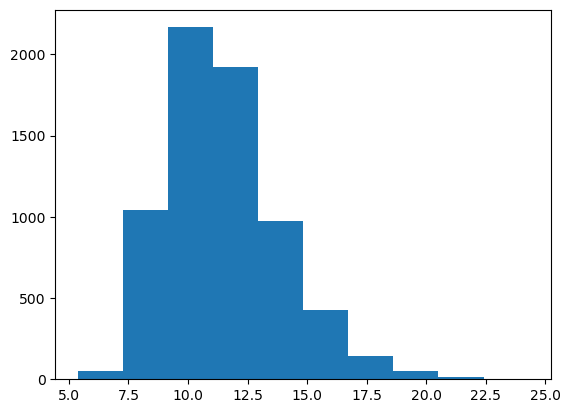

In [106]:
plt.hist(df_admissions_pred_from_pred['admissions_predicted'])